
---
# Implementation of **Value Iteration**, **Policy Iteration** and **Modified Policy Iteration(MDP)** algorithms.

The following is the MDP.py implementation from the sceleton code in A1 part 1.

---


In [1]:
import numpy as np


class MDP:
    '''A simple MDP class.  It includes the following members'''

    def __init__(self, T, R, discount):
        '''Constructor for the MDP class

        Inputs:
        T -- Transition function: |A| x |S| x |S'| array
        R -- Reward function: |A| x |S| array
        discount -- discount factor: scalar in [0,1)

        The constructor verifies that the inputs are valid and sets
        corresponding variables in a MDP object'''

        assert T.ndim == 3, "Invalid transition function: it should have 3 dimensions"
        self.nActions = T.shape[0]
        self.nStates = T.shape[1]
        assert T.shape == (
        self.nActions, self.nStates, self.nStates), "Invalid transition function: it has dimensionality " + repr(
            T.shape) + ", but it should be (nActions,nStates,nStates)"
        assert (abs(T.sum(
            2) - 1) < 1e-5).all(), "Invalid transition function: some transition probability does not equal 1"
        self.T = T
        assert R.ndim == 2, "Invalid reward function: it should have 2 dimensions"
        assert R.shape == (self.nActions, self.nStates), "Invalid reward function: it has dimensionality " + repr(
            R.shape) + ", but it should be (nActions,nStates)"
        self.R = R
        assert 0 <= discount < 1, "Invalid discount factor: it should be in [0,1)"
        self.discount = discount

    def valueIteration(self, initialV, nIterations=np.inf, tolerance=0.01):
        '''Value iteration procedure
        V <-- max_a R^a + gamma T^a V

        Inputs:
        initialV -- Initial value function: array of |S| entries
        nIterations -- limit on the # of iterations: scalar (default: infinity)
        tolerance -- threshold on ||V^n-V^n+1||_inf: scalar (default: 0.01)

        Outputs: 
        V -- Value function: array of |S| entries
        iterId -- # of iterations performed: scalar
        epsilon -- ||V^n-V^n+1||_inf: scalar'''

        V = initialV
        iterId = 0
        epsilon = np.inf
        policy = np.zeros(len(initialV), dtype=int)

        """
        print("===========================================================================")
        print("Executing Value Iteration")
        print("--------------------------------------------")
        """

        while iterId < nIterations and epsilon > tolerance:
            Ta_V = np.matmul(self.T, V)
            gamma_Ta_V = self.discount * Ta_V
            all_possible_values = self.R + gamma_Ta_V
            policy = np.argmax(all_possible_values, axis=0)  # Choose the best actions for each state, policy means keep
            V_new = np.amax((all_possible_values), axis=0)  # Choose the best action values for each state
            # np.round/np.around does not work for 0.5 so not reducing to 2 decimal places
            V_diff = (V_new - V)
            V = V_new
            epsilon = np.linalg.norm(V_diff, np.inf)
            #print("Iteration : " + str(iterId) + " V : " + str(V) + " Policy: " + str(policy) + " epsilon: " + str(epsilon))
            iterId = iterId + 1

        """
        print("--------------------------------------------")
        print("Final State values after " + str(iterId) + " iterations , V: " + str(V) + " Policy: " + str(policy))
        print("===========================================================================")
        """

        return [V, iterId, epsilon]

    def extractPolicy(self, V):
        '''Procedure to extract a policy from a value function
        pi <-- argmax_a R^a + gamma T^a V

        Inputs:
        V -- Value function: array of |S| entries

        Output:
        policy -- Policy: array of |S| entries'''

        """
        print("***************************************************************")
        print("Executing Policy Extraction")
        print("--------------------------------------------")
        """

        all_possible_values = (self.R + (self.discount*(np.matmul(self.T, V))))  # Get values for all possible state transition in this state

        """
        print("All Values for All possible state transition: ")
        print(all_possible_values)
        """

        policy = np.argmax(all_possible_values, axis=0)  # Choose the best actions for each state, policy means keep

        """
        print("Extracted Policy : " + str(policy))
        print("--------------------------------------------")
        """

        """
        # track of action chosen at timestamp t, instead of choosing only value
        max_values = [all_possible_values[policy[i]][i] for i in range(len(policy))]
        print("Values Corresponding to Selected Policies: " + str(max_values))
        print("***************************************************************")
        """

        return policy

    def evaluatePolicy(self, policy):
        '''Evaluate a policy by solving a system of linear equations
        V^pi = R^pi + gamma T^pi V^pi

        Input:
        policy -- Policy: array of |S| entries

        Ouput:
        V -- Value function: array of |S| entries'''

        """
        print("***************************************************************")
        print("Executing Policy Evaluation")
        print("--------------------------------------------")
        print("Policy : " + str(policy))
        print("Evaluating a policy by solving a system of linear equations")
        """

        R_policy = np.array([self.R[policy[i]][i] for i in range(len(policy))])
        T_policy = np.array([self.T[policy[i]][i] for i in range(len(policy))])
        gamma_T_policy = self.discount * T_policy
        assert gamma_T_policy.shape[0] == gamma_T_policy.shape[1], "gamma_T_policy matrix should be square"
        V = np.matmul(np.linalg.inv(np.identity(len(policy)) - gamma_T_policy), R_policy)

        """
        print("V : " + str(V))
        print("***************************************************************")
        """

        return V

    def policyIteration(self, initialPolicy, nIterations=np.inf):
        '''Policy iteration procedure: alternate between policy
        evaluation (solve V^pi = R^pi + gamma T^pi V^pi) and policy
        improvement (pi <-- argmax_a R^a + gamma T^a V^pi).

        Inputs:
        initialPolicy -- Initial policy: array of |S| entries
        nIterations -- limit on # of iterations: scalar (default: inf)

        Outputs: 
        policy -- Policy: array of |S| entries
        V -- Value function: array of |S| entries
        iterId -- # of iterations peformed by modified policy iteration: scalar'''

        policy = initialPolicy  # np.zeros(self.nStates)
        V = np.zeros(self.nStates)
        iterId = 0

        """
        print("===========================================================================")
        print("Executing Policy Iteration")
        print("--------------------------------------------")
        """

        while iterId < nIterations:
            V = self.evaluatePolicy(policy)
            #print("Iteration : " + str(iterId) + " V : " + str(V) + " policy : " + str(policy))

            policy_new = self.extractPolicy(V)
            iterId = iterId + 1

            if np.array_equal(policy_new, policy):
                break

            policy = policy_new

        """
        print("Iteration : " + str(iterId) + " V : " + str(V) + " policy : " + str(policy))
        print("--------------------------------------------")
        print("Final policy after " + str(iterId) + " iterations , policy: " + str(policy))
        print("===========================================================================")
        """

        return [policy, V, iterId]

    def evaluatePolicyPartially(self, policy, initialV, nIterations=np.inf, tolerance=0.01):
        '''Partial policy evaluation:
        Repeat V^pi <-- R^pi + gamma T^pi V^pi

        Inputs:
        policy -- Policy: array of |S| entries
        initialV -- Initial value function: array of |S| entries
        nIterations -- limit on the # of iterations: scalar (default: infinity)
        tolerance -- threshold on ||V^n-V^n+1||_inf: scalar (default: 0.01)

        Outputs: 
        V -- Value function: array of |S| entries
        iterId -- # of iterations performed: scalar
        epsilon -- ||V^n-V^n+1||_inf: scalar'''

        # temporary values to ensure that the code compiles until this
        # function is coded
        V = initialV  # np.zeros(self.nStates)
        iterId = 0
        epsilon = np.inf

        """
        print("***************************************************************")
        print("Executing Partial Policy Evaluation")
        print("--------------------------------------------")
        print("Policy : " + str(policy))
        print("Evaluating a policy by repeating " + str(nIterations) + " times.")
        print("Iteration : " + str(iterId) + " V : " + str(V) + " Policy: " + str(policy))
        """

        while iterId < nIterations and epsilon > tolerance:
            iterId = iterId+1
            R_policy = np.array([self.R[policy[i]][i] for i in range(len(policy))])
            T_policy = np.array([self.T[policy[i]][i] for i in range(len(policy))])
            Vnew = R_policy + (self.discount * np.matmul(T_policy, V))
            epsilon = np.linalg.norm((Vnew-V), np.inf)
            V = Vnew

            #print("Iteration : " + str(iterId) + " V : " + str(V) + " Policy: " + str(policy) + " epsilon : " + str(epsilon))

        """
        print("V : " + str(V))
        print("***************************************************************")
        """

        return [V, iterId, epsilon]

    def modifiedPolicyIteration(self, initialPolicy, initialV, nEvalIterations=5, nIterations=np.inf, tolerance=0.01):
        '''Modified policy iteration procedure: alternate between
        partial policy evaluation (repeat a few times V^pi <-- R^pi + gamma T^pi V^pi)
        and policy improvement (pi <-- argmax_a R^a + gamma T^a V^pi)

        Inputs:
        initialPolicy -- Initial policy: array of |S| entries
        initialV -- Initial value function: array of |S| entries
        nEvalIterations -- limit on # of iterations to be performed in each partial policy evaluation: scalar (default: 5)
        nIterations -- limit on # of iterations to be performed in modified policy iteration: scalar (default: inf)
        tolerance -- threshold on ||V^n-V^n+1||_inf: scalar (default: 0.01)

        Outputs: 
        policy -- Policy: array of |S| entries
        V -- Value function: array of |S| entries
        iterId -- # of iterations peformed by modified policy iteration: scalar
        epsilon -- ||V^n-V^n+1||_inf: scalar'''

        # temporary values to ensure that the code compiles until this
        # function is coded
        policy = initialPolicy
        V = initialV
        iterId = 0
        epsilon = np.inf

        """
        print("===========================================================================")
        print("Executing Modified Policy Iteration")
        print("--------------------------------------------")
        print("Iteration : " + str(iterId) + " policy : " + str(policy))
        """

        while iterId < nIterations and epsilon > tolerance:
            iterId = iterId + 1
            Vn, _ , _  = self.evaluatePolicyPartially(policy, V, nEvalIterations, tolerance)
            #print("Vn : " + str(Vn))
            all_possible_values = (self.R + (self.discount * np.matmul(self.T,Vn)))  # Get values for all possible state transition in this state
            policy = np.argmax(all_possible_values, axis=0)  # Choose the best actions for each state, policy means keep

            Vn_plus_1 = [all_possible_values[policy[i]][i] for i in range(len(policy))]
            V_diff = (Vn_plus_1 - Vn)
            V = Vn_plus_1
            epsilon = np.linalg.norm(V_diff, np.inf)
            #print("Iteration : " + str(iterId) + " policy : " + str(policy))

        """
        print("--------------------------------------------")
        print("Final policy after " + str(iterId) + " iterations , policy: " + str(policy))
        print("===========================================================================")
        """

        return [policy, V, iterId, epsilon]


## Testing value iteration, policy iteration and modified policy iteration for Markov decision processes with provided example
---

The following is the TestMDP.py file to test out the the simple MDP example from Lecture 1b Slides 17-18.

---


In [2]:
''' Construct simple MDP as described in Lecture 1b Slides 17-18'''
# Transition function: |A| x |S| x |S'| array
T = np.array([[[0.5,0.5,0,0],[0,1,0,0],[0.5,0.5,0,0],[0,1,0,0]],[[1,0,0,0],[0.5,0,0,0.5],[0.5,0,0.5,0],[0,0,0.5,0.5]]])
# Reward function: |A| x |S| array
R = np.array([[0,0,10,10],[0,0,10,10]])
# Discount factor: scalar in [0,1)
discount = 0.9        
# MDP object
mdp = MDP(T,R,discount)


---

Testing valueIteration & extractPolicy procedure using simple MDP example from Lecture 1b Slides 17-18.

---


In [3]:
'''Test each procedure'''
[V,nIterations,epsilon] = mdp.valueIteration(initialV=np.zeros(mdp.nStates))
policy = mdp.extractPolicy(V)
print("V : " + str(V))
print("nIterations : " + str(nIterations))
print("Policy : " + str(policy))

V : [31.49636306 38.51527513 43.935435   54.1128575 ]
nIterations : 58
Policy : [0 1 1 1]



---


Testing evaluatePolicy procedure using simple MDP example from Lecture 1b Slides 17-18. We see the results from evaluatePolicy match from the previous valueIteration and extractPolicy procedures

---


In [4]:
V = mdp.evaluatePolicy(np.array([1,0,1,0]))
print("Value corresponding to policy [1,0,1,0]: " + str(V))

V = mdp.evaluatePolicy(np.array([0,1,1,1]))
print("Value corresponding to policy [0,1,1,1]: " + str(V))

Value corresponding to policy [1,0,1,0]: [ 0.          0.         18.18181818 10.        ]
Value corresponding to policy [0,1,1,1]: [31.58510431 38.60401638 44.02417625 54.20159875]



---

Testing policyIteration procedure using simple MDP example from Lecture 1b Slides 17-18. We see that the policy result and value results match the valueIteration procedure.

---


In [5]:
[policy,V,iterId] = mdp.policyIteration(np.array([0,0,0,0]))
print("V : " + str(V))
print("nIterations : " + str(iterId))
print("Epsilon : " + str(policy))

V : [31.58510431 38.60401638 44.02417625 54.20159875]
nIterations : 2
Epsilon : [0 1 1 1]



---

Testing modifiedPolicyIteration(MDP) procedure using simple MDP example from Lecture 1b Slides 17-18. We see that the policy result and value results match the valueIteration procedure.

---



In [6]:
[V,iterId,epsilon] = mdp.evaluatePolicyPartially(np.array([1,0,1,0]),np.array([0,10,0,13]))
[policy,V,iterId,tolerance] = mdp.modifiedPolicyIteration(np.array([1,0,1,0]),np.array([0,10,0,13]))
print("V : " + str(V))
print("nIterations : " + str(iterId))
print("Policy : " + str(policy))

V : [31.50605365934906, 38.524965727978426, 43.945125603197766, 54.12254810271034]
nIterations : 11
Policy : [0 1 1 1]




---

## **Maze Problem** solving using value iteration, policy iteration and modified policy iteration.

---


In [7]:
import numpy as np

''' Construct a simple maze MDP

  Grid world layout:

  ---------------------
  |  0 |  1 |  2 |  3 |
  ---------------------
  |  4 |  5 |  6 |  7 |
  ---------------------
  |  8 |  9 | 10 | 11 |
  ---------------------
  | 12 | 13 | 14 | 15 |
  ---------------------

  Goal state: 14 
  Bad state: 9
  End state: 16

  The end state is an absorbing state that the agent transitions 
  to after visiting the goal state.

  There are 17 states in total (including the end state) 
  and 4 actions (up, down, left, right).'''

# Transition function: |A| x |S| x |S'| array
T = np.zeros([4, 17, 17])
a = 0.7;  # intended move
b = 0.15;  # lateral move

# up (a = 0)

T[0, 0, 0] = a + b;
T[0, 0, 1] = b;

T[0, 1, 0] = b;
T[0, 1, 1] = a;
T[0, 1, 2] = b;

T[0, 2, 1] = b;
T[0, 2, 2] = a;
T[0, 2, 3] = b;

T[0, 3, 2] = b;
T[0, 3, 3] = a + b;

T[0, 4, 4] = b;
T[0, 4, 0] = a;
T[0, 4, 5] = b;

T[0, 5, 4] = b;
T[0, 5, 1] = a;
T[0, 5, 6] = b;

T[0, 6, 5] = b;
T[0, 6, 2] = a;
T[0, 6, 7] = b;

T[0, 7, 6] = b;
T[0, 7, 3] = a;
T[0, 7, 7] = b;

T[0, 8, 8] = b;
T[0, 8, 4] = a;
T[0, 8, 9] = b;

T[0, 9, 8] = b;
T[0, 9, 5] = a;
T[0, 9, 10] = b;

T[0, 10, 9] = b;
T[0, 10, 6] = a;
T[0, 10, 11] = b;

T[0, 11, 10] = b;
T[0, 11, 7] = a;
T[0, 11, 11] = b;

T[0, 12, 12] = b;
T[0, 12, 8] = a;
T[0, 12, 13] = b;

T[0, 13, 12] = b;
T[0, 13, 9] = a;
T[0, 13, 14] = b;

T[0, 14, 16] = 1;

T[0, 15, 11] = a;
T[0, 15, 14] = b;
T[0, 15, 15] = b;

T[0, 16, 16] = 1;

# down (a = 1)

T[1, 0, 0] = b;
T[1, 0, 4] = a;
T[1, 0, 1] = b;

T[1, 1, 0] = b;
T[1, 1, 5] = a;
T[1, 1, 2] = b;

T[1, 2, 1] = b;
T[1, 2, 6] = a;
T[1, 2, 3] = b;

T[1, 3, 2] = b;
T[1, 3, 7] = a;
T[1, 3, 3] = b;

T[1, 4, 4] = b;
T[1, 4, 8] = a;
T[1, 4, 5] = b;

T[1, 5, 4] = b;
T[1, 5, 9] = a;
T[1, 5, 6] = b;

T[1, 6, 5] = b;
T[1, 6, 10] = a;
T[1, 6, 7] = b;

T[1, 7, 6] = b;
T[1, 7, 11] = a;
T[1, 7, 7] = b;

T[1, 8, 8] = b;
T[1, 8, 12] = a;
T[1, 8, 9] = b;

T[1, 9, 8] = b;
T[1, 9, 13] = a;
T[1, 9, 10] = b;

T[1, 10, 9] = b;
T[1, 10, 14] = a;
T[1, 10, 11] = b;

T[1, 11, 10] = b;
T[1, 11, 15] = a;
T[1, 11, 11] = b;

T[1, 12, 12] = a + b;
T[1, 12, 13] = b;

T[1, 13, 12] = b;
T[1, 13, 13] = a;
T[1, 13, 14] = b;

T[1, 14, 16] = 1;

T[1, 15, 14] = b;
T[1, 15, 15] = a + b;

T[1, 16, 16] = 1;

# left (a = 2)

T[2, 0, 0] = a + b;
T[2, 0, 4] = b;

T[2, 1, 1] = b;
T[2, 1, 0] = a;
T[2, 1, 5] = b;

T[2, 2, 2] = b;
T[2, 2, 1] = a;
T[2, 2, 6] = b;

T[2, 3, 3] = b;
T[2, 3, 2] = a;
T[2, 3, 7] = b;

T[2, 4, 0] = b;
T[2, 4, 4] = a;
T[2, 4, 8] = b;

T[2, 5, 1] = b;
T[2, 5, 4] = a;
T[2, 5, 9] = b;

T[2, 6, 2] = b;
T[2, 6, 5] = a;
T[2, 6, 10] = b;

T[2, 7, 3] = b;
T[2, 7, 6] = a;
T[2, 7, 11] = b;

T[2, 8, 4] = b;
T[2, 8, 8] = a;
T[2, 8, 12] = b;

T[2, 9, 5] = b;
T[2, 9, 8] = a;
T[2, 9, 13] = b;

T[2, 10, 6] = b;
T[2, 10, 9] = a;
T[2, 10, 14] = b;

T[2, 11, 7] = b;
T[2, 11, 10] = a;
T[2, 11, 15] = b;

T[2, 12, 8] = b;
T[2, 12, 12] = a + b;

T[2, 13, 9] = b;
T[2, 13, 12] = a;
T[2, 13, 13] = b;

T[2, 14, 16] = 1;

T[2, 15, 11] = b;
T[2, 15, 14] = a;
T[2, 15, 15] = b;

T[2, 16, 16] = 1;

# right (a = 3)

T[3, 0, 0] = b;
T[3, 0, 1] = a;
T[3, 0, 4] = b;

T[3, 1, 1] = b;
T[3, 1, 2] = a;
T[3, 1, 5] = b;

T[3, 2, 2] = b;
T[3, 2, 3] = a;
T[3, 2, 6] = b;

T[3, 3, 3] = a + b;
T[3, 3, 7] = b;

T[3, 4, 0] = b;
T[3, 4, 5] = a;
T[3, 4, 8] = b;

T[3, 5, 1] = b;
T[3, 5, 6] = a;
T[3, 5, 9] = b;

T[3, 6, 2] = b;
T[3, 6, 7] = a;
T[3, 6, 10] = b;

T[3, 7, 3] = b;
T[3, 7, 7] = a;
T[3, 7, 11] = b;

T[3, 8, 4] = b;
T[3, 8, 9] = a;
T[3, 8, 12] = b;

T[3, 9, 5] = b;
T[3, 9, 10] = a;
T[3, 9, 13] = b;

T[3, 10, 6] = b;
T[3, 10, 11] = a;
T[3, 10, 14] = b;

T[3, 11, 7] = b;
T[3, 11, 11] = a;
T[3, 11, 15] = b;

T[3, 12, 8] = b;
T[3, 12, 13] = a;
T[3, 12, 12] = b;

T[3, 13, 9] = b;
T[3, 13, 14] = a;
T[3, 13, 13] = b;

T[3, 14, 16] = 1;

T[3, 15, 11] = b;
T[3, 15, 15] = a + b;

T[3, 16, 16] = 1;

# Reward function: |A| x |S| array
R = -1 * np.ones([4, 17]);

# set rewards
R[:, 14] = 100;  # goal state
R[:, 9] = -70;  # bad state
R[:, 16] = 0;  # end state

# Discount factor: scalar in [0,1)
discount = 0.95

# MDP object
mdp = MDP(T, R, discount)




---

## Part I.I: Calculating **policy**, **value function** and **number of iterations** needed by **value iteration** in Maze Problem

---
### Testing Parameters

*   Tolerance : 0.01. Used following line in *mdp.valueIteration* procedure
```
#  tolerance=0.01
```
*   Initial Value Function: Zero for all states. Used following line in *mdp.valueIteration* procedure
```
#  initialV=np.zeros(mdp.nStates)
```

---

### Results

1.   **Policy** : [3 3 1 1 3 0 1 1 1 3 3 1 3 3 0 2 0]
2.   **Value Function** : [ 49.66895295  55.27161487  61.57363146  65.87460207  48.00953133 52.30188839  68.13923599  73.25481858  50.22617115  -0.42481753
  77.06611566  81.36344171  66.36179067  76.31383816 100.
  89.90583635   0.        ]
3.   **Number of Iterations** : 26

---


In [8]:
[V, nIterations, epsilon] = mdp.valueIteration(initialV=np.zeros(mdp.nStates), tolerance=0.01)
policy = mdp.extractPolicy(V)

In [9]:
print("==================================================================")
print("MDPMaze Value Iteration:")
print("Policy " + str(policy))
print("Value Function: " + str(V))
print("Number of Iterations: " + str(nIterations))
print("==================================================================\n\n")


MDPMaze Value Iteration:
Policy [3 3 1 1 3 0 1 1 1 3 3 1 3 3 0 2 0]
Value Function: [ 49.66895295  55.27161487  61.57363146  65.87460207  48.00953133
  52.30188839  68.13923599  73.25481858  50.22617115  -0.42481753
  77.06611566  81.36344171  66.36179067  76.31383816 100.
  89.90583635   0.        ]
Number of Iterations: 26





---

## Part I.II: Calculating **policy**, **value function** and **number of iterations** needed by **policy iteration** in Maze Problem

---

### Testing Parameters

*   Initial Policy: Uses action 0 in all states. Used following line in *mdp.policyIteration* procedure
```
#  initialPolicy = np.zeros(mdp.nStates, dtype=int)
```

---

### Results


1.   **Policy** : [3 3 1 1 3 0 1 1 1 3 3 1 3 3 0 2 0]
2.   **Value Function** : [ 49.69078867  55.28617892  61.58230087  65.87897994  48.03187576  52.32047965  68.1447605   73.25676304  50.23031164  -0.41942079
  77.06767431  81.36397885  66.36430029  76.31513999 100.
  89.90596733   0.        ]
3.   **Number of Iterations** : 7

---



In [10]:
[policy, V, nIterations] = mdp.policyIteration(initialPolicy = np.zeros(mdp.nStates, dtype=int))


In [11]:
print("==================================================================")
print("MDPMaze policy Iteration:")
print("Policy " + str(policy))
print("Value Function: " + str(V))
print("Number of Iterations: " + str(nIterations))
print("==================================================================\n\n")

MDPMaze policy Iteration:
Policy [3 3 1 1 3 0 1 1 1 3 3 1 3 3 0 2 0]
Value Function: [ 49.69078867  55.28617892  61.58230087  65.87897994  48.03187576
  52.32047965  68.1447605   73.25676304  50.23031164  -0.41942079
  77.06767431  81.36397885  66.36430029  76.31513999 100.
  89.90596733   0.        ]
Number of Iterations: 7





---

## Part I.III: Calculating **number of iterations** to converge when varying number of iterations in partial policy evaluation from 1 to 10 in Maze Problem

---

### Testing Parameters

*   Tolerance : 0.01 . Used following line in *mdp.modifiedPolicyIteration* procedure
```
#  tolerance=0.01
```
*   Initial Policy : Uses action 0 in all states . Used following line in *mdp.modifiedPolicyIteration* procedure
```
#  initialPolicy = np.zeros(mdp.nStates, dtype=int)
```
*   Initial Value Function : Assigned 0 to in all states . Used following line in *mdp.modifiedPolicyIteration* procedure
```
#  initialPolicy = initialV = np.zeros(mdp.nStates)
```
*   Number of iterations in Partial Policy Evaluation : 0 to 10
---

### Results

| Number of Iterations in Partial Policy Evaluation | Number of Iterations for Convergence |
| --- | --- | 
| 1 | 14 | 
| 2 | 10 | 
| 3 | 8 | 
| 4 | 8 | 
| 5 | 7 | 
| 6 | 7 | 
| 7 | 7 | 
| 8 | 6 | 
| 9 | 7 | 
| 10 | 7 | 


---


In [12]:

print("==================================================================")
print("MDPMaze Modifier Policy Iteration:")
for nIterPPE in range(1, 11):
    [policy, V, nIterations, epsilon] = mdp.modifiedPolicyIteration(initialPolicy = np.zeros(mdp.nStates, dtype=int),
                                                                    initialV = np.zeros(mdp.nStates), nEvalIterations=nIterPPE,
                                                                    tolerance=0.01)
    print("# of Iterations in Partial Policy Evaluation: " + str(nIterPPE) + " , # of Iterations for Convergence: " + str(nIterations))
print("==================================================================\n\n")


MDPMaze Modifier Policy Iteration:
# of Iterations in Partial Policy Evaluation: 1 , # of Iterations for Convergence: 14
# of Iterations in Partial Policy Evaluation: 2 , # of Iterations for Convergence: 10
# of Iterations in Partial Policy Evaluation: 3 , # of Iterations for Convergence: 8
# of Iterations in Partial Policy Evaluation: 4 , # of Iterations for Convergence: 8
# of Iterations in Partial Policy Evaluation: 5 , # of Iterations for Convergence: 7
# of Iterations in Partial Policy Evaluation: 6 , # of Iterations for Convergence: 7
# of Iterations in Partial Policy Evaluation: 7 , # of Iterations for Convergence: 7
# of Iterations in Partial Policy Evaluation: 8 , # of Iterations for Convergence: 6
# of Iterations in Partial Policy Evaluation: 9 , # of Iterations for Convergence: 7
# of Iterations in Partial Policy Evaluation: 10 , # of Iterations for Convergence: 7




---
## Part I.IV: Discussion
---
| Convergence Iterations in Value Iteration | Convergence Iterations in Policy Iteration | Convergence Iterations in Partial Policy Iteration | 
| --- | --- | --- | 
| 26 | 7 | 6 (For 8 iterations in partial policy evaluation) | 

In the maze problem, there are a total of |S| = 17 states and |A| = 4 actions. For MDP problem, we see that a k=8 value produces the least number of iterations (6) for convergence for given range of k values (1 to 10). **To recap, k denotes the number of iterations in partial policy evaluation step for MDP.**

Increases the number of iterations in partial policy evaluation results in slowly decreasing the number of iterations in MDP for convergence.

As number of Actions |A| (= 4) < number of states |S| (=17), runtime for each iteration in 
*   **Value Iteration** reduces to O(|S|<sup>2</sup>|A|)
*   **Policy Iteration** reduces to O(|S|<sup>3</sup>) 
[As |S| > |A|, |S|<sup>3</sup> > |S|<sup>2</sup>|A| and O(|S|<sup>3</sup> + |S|<sup>2</sup>|A|) reduces to O(|S|<sup>3</sup>)]  
*   **MDP** reduces to O(k|S|<sup>2</sup>) when k > |A| (number of partial policy evaluation >= 5) and  O(|S|<sup>2</sup>|A|) when k <= |A| (number of partial policy evaluation is between 1 to 4 inclusive)

For **k > 4**, each iteration in MDP will be less complex than policy iteration (k|S|<sup>2</sup> < |S|<sup>2</sup>) until k > |S|, or number of iterations in partial policy evaluation crosses 17. However, between 4 < k < 17, each iteration in MDP will still be more complex than value iteration. 

For **k <= 4**, each iteration in MDP will be less complex than policy iteration [O(k|S|<sup>2</sup>) < O(|S|<sup>2</sup>)] and value iteration [O(k|S|<sup>2</sup>) < O(|S|<sup>2</sup>|A|)]. 




---

# Part II: Q-Learning Algorithm

---



---



In [13]:
import numpy as np
import matplotlib.pyplot as plt

class RL:
    def __init__(self, mdp, sampleReward):
        '''Constructor for the RL class

        Inputs:
        mdp -- Markov decision process (T, R, discount)
        sampleReward -- Function to sample rewards (e.g., bernoulli, Gaussian).
        This function takes one argument: the mean of the distributon and 
        returns a sample from the distribution.
        '''

        self.mdp = mdp
        self.sampleReward = sampleReward
        #self.counterStateActionPair = np.zeros((self.mdp.nActions, self.mdp.nStates), dtype=np.int)

    def sampleRewardAndNextState(self, state, action):
        '''Procedure to sample a reward and the next state
        reward ~ Pr(r)
        nextState ~ Pr(s'|s,a)

        Inputs:
        state -- current state
        action -- action to be executed

        Outputs: 
        reward -- sampled reward
        nextState -- sampled next state
        '''

        reward = self.sampleReward(self.mdp.R[action, state])
        cumProb = np.cumsum(self.mdp.T[action, state, :])
        nextState = np.where(cumProb >= np.random.rand(1))[0][0]
        return [reward, nextState]

    def qLearning(self, s0, initialQ, nEpisodes, nSteps, epsilon=0, temperature=0.0):
        '''qLearning algorithm.  
        When epsilon > 0: perform epsilon exploration (i.e., with probability epsilon, select action at random )
        When epsilon == 0 and temperature > 0: perform Boltzmann exploration with temperature parameter
        When epsilon == 0 and temperature == 0: no exploration (i.e., selection action with best Q-value)

        Inputs:
        s0 -- initial state
        initialQ -- initial Q function (|A|x|S| array)
        nEpisodes -- # of episodes (one episode consists of a trajectory of nSteps that starts in s0
        nSteps -- # of steps per episode
        epsilon -- probability with which an action is chosen at random
        temperature -- parameter that regulates Boltzmann exploration

        Outputs: 
        Q -- final Q function (|A|x|S| array)
        policy -- final policy
        '''


        TRIAL = 100
        avg_cumulative_rewards = np.zeros(nEpisodes)

        Q = initialQ
        policy = np.zeros(self.mdp.nStates, int)

        for trial in range(TRIAL):
            Q = initialQ
            policy = np.zeros(self.mdp.nStates, int)


            cumulative_rewards = np.zeros(nEpisodes)

            for episode in range(nEpisodes):

                s = s0  # Starting each episode at s0 according to specifications
                counterStateActionPair = np.zeros((self.mdp.nActions, self.mdp.nStates), dtype=np.int)

                for t in range(nSteps):

                    #print("Trial :" + str(trial+1) + " Episode : " + str(episode + 1) + " Timestamp t : " + str(t + 1))

                    # Where the loop starts

                    #   select action via q value (epsilon-greedy or Bolzman temperature or greedy)
                    #   Initializing action with a random value
                    a = np.argmax(Q, axis=0)[s]  # Choosing the best action a* = argmax_a Q(s,a)
                    if epsilon > 0:
                        # perform epsilon exploration (i.e., with probability epsilon, select action at random )
                        #print("Epsilon Greedy Policy")
                        currentProbValue = np.random.random_sample()
                        #print("Current val: " + str(currentProbValue) + " Epsilon: " + str(epsilon))

                        if currentProbValue <= epsilon:
                            #print("Executing Random Action")
                            a = np.random.randint(self.mdp.nActions)
                        else:
                            #print("Chosen Action with best Q-value")
                            a = np.argmax(Q, axis=0)[s]  # Choosing the best action a* = argmax_a Q(s,a)
                    else:
                        if temperature > 0:
                            # perform Boltzmann exploration with temperature parameter
                            #print("Boltzman Exploration Policy")
                            all_a = Q[:, s] / temperature
                            pr_all_a = (np.exp(all_a) / np.sum(np.exp(all_a)))

                            a = 0
                            currentProbValue = np.random.random_sample()
                            currentPrSum = 0.0
                            while a < (len(pr_all_a)-1):
                                currentPrSum += pr_all_a[a]
                                if currentProbValue <= currentPrSum:
                                    break

                                a += 1

                            #print(currentProbValue)
                            #print(pr_all_a)
                            #print(a)
                            #a = np.argmax(pr_all_a)

                        else:
                            # no exploration (i.e., selection action with best Q-value)
                            #print("Chosen Action with best Q-value")
                            a = np.argmax(Q, axis=0)[s]  # Choosing the best action a* = argmax_a Q(s,a)

                    #   End of Action selection

                    #print("action: " + str(a) + " at State " + str(s))

                    # Execute a
                    [reward, nextState] = self.sampleRewardAndNextState(s, a)
                    #print("Next State : " + str(nextState))
                    #print("Reward : " + str(reward))
                    counterStateActionPair[a][s] += 1

                    learningRate = (1.0 / counterStateActionPair[a][s])
                    Q[a][s] = Q[a][s] + (learningRate * (reward
                                                         + (self.mdp.discount * np.amax(Q[:, nextState]))
                                                         - Q[a][s]
                                                         )
                                         )
                    cumulative_rewards[episode] += (np.power(self.mdp.discount, t) * reward)
                    policy[s] = a
                    s = nextState

                """
                print("Q : " + str(Q))
                print("Policy : " + str(policy))
                print("\n")
                """

            #print("Cumulative Rewards : " + str(cumulative_rewards))

            avg_cumulative_rewards += cumulative_rewards

        avg_cumulative_rewards = avg_cumulative_rewards / TRIAL

        xAxis = range(1, (len(avg_cumulative_rewards)+1))
        yAxis = avg_cumulative_rewards
        pltLabel = "Epsilon : " + str(epsilon) + "\nTemp : " + str(temperature)
        plt.plot(xAxis, yAxis, label= pltLabel)


        return [Q, policy]


In [14]:
import numpy as np
import matplotlib.pyplot as plt

''' Construct a simple maze MDP

  Grid world layout:

  ---------------------
  |  0 |  1 |  2 |  3 |
  ---------------------
  |  4 |  5 |  6 |  7 |
  ---------------------
  |  8 |  9 | 10 | 11 |
  ---------------------
  | 12 | 13 | 14 | 15 |
  ---------------------

  Goal state: 14 
  Bad state: 9
  End state: 16

  The end state is an absorbing state that the agent transitions 
  to after visiting the goal state.

  There are 17 states in total (including the end state) 
  and 4 actions (up, down, left, right).'''

# Transition function: |A| x |S| x |S'| array
T = np.zeros([4,17,17])
a = 0.7;  # intended move
b = 0.15;  # lateral move

# up (a = 0)

T[0,0,0] = a+b;
T[0,0,1] = b;

T[0,1,0] = b;
T[0,1,1] = a;
T[0,1,2] = b;

T[0,2,1] = b;
T[0,2,2] = a;
T[0,2,3] = b;

T[0,3,2] = b;
T[0,3,3] = a+b;

T[0,4,4] = b;
T[0,4,0] = a;
T[0,4,5] = b;

T[0,5,4] = b;
T[0,5,1] = a;
T[0,5,6] = b;

T[0,6,5] = b;
T[0,6,2] = a;
T[0,6,7] = b;

T[0,7,6] = b;
T[0,7,3] = a;
T[0,7,7] = b;

T[0,8,8] = b;
T[0,8,4] = a;
T[0,8,9] = b;

T[0,9,8] = b;
T[0,9,5] = a;
T[0,9,10] = b;

T[0,10,9] = b;
T[0,10,6] = a;
T[0,10,11] = b;

T[0,11,10] = b;
T[0,11,7] = a;
T[0,11,11] = b;

T[0,12,12] = b;
T[0,12,8] = a;
T[0,12,13] = b;

T[0,13,12] = b;
T[0,13,9] = a;
T[0,13,14] = b;

T[0,14,16] = 1;

T[0,15,11] = a;
T[0,15,14] = b;
T[0,15,15] = b;

T[0,16,16] = 1;

# down (a = 1)

T[1,0,0] = b;
T[1,0,4] = a;
T[1,0,1] = b;

T[1,1,0] = b;
T[1,1,5] = a;
T[1,1,2] = b;

T[1,2,1] = b;
T[1,2,6] = a;
T[1,2,3] = b;

T[1,3,2] = b;
T[1,3,7] = a;
T[1,3,3] = b;

T[1,4,4] = b;
T[1,4,8] = a;
T[1,4,5] = b;

T[1,5,4] = b;
T[1,5,9] = a;
T[1,5,6] = b;

T[1,6,5] = b;
T[1,6,10] = a;
T[1,6,7] = b;

T[1,7,6] = b;
T[1,7,11] = a;
T[1,7,7] = b;

T[1,8,8] = b;
T[1,8,12] = a;
T[1,8,9] = b;

T[1,9,8] = b;
T[1,9,13] = a;
T[1,9,10] = b;

T[1,10,9] = b;
T[1,10,14] = a;
T[1,10,11] = b;

T[1,11,10] = b;
T[1,11,15] = a;
T[1,11,11] = b;

T[1,12,12] = a+b;
T[1,12,13] = b;

T[1,13,12] = b;
T[1,13,13] = a;
T[1,13,14] = b;

T[1,14,16] = 1;

T[1,15,14] = b;
T[1,15,15] = a+b;

T[1,16,16] = 1;

# left (a = 2)

T[2,0,0] = a+b;
T[2,0,4] = b;

T[2,1,1] = b;
T[2,1,0] = a;
T[2,1,5] = b;

T[2,2,2] = b;
T[2,2,1] = a;
T[2,2,6] = b;

T[2,3,3] = b;
T[2,3,2] = a;
T[2,3,7] = b;

T[2,4,0] = b;
T[2,4,4] = a;
T[2,4,8] = b;

T[2,5,1] = b;
T[2,5,4] = a;
T[2,5,9] = b;

T[2,6,2] = b;
T[2,6,5] = a;
T[2,6,10] = b;

T[2,7,3] = b;
T[2,7,6] = a;
T[2,7,11] = b;

T[2,8,4] = b;
T[2,8,8] = a;
T[2,8,12] = b;

T[2,9,5] = b;
T[2,9,8] = a;
T[2,9,13] = b;

T[2,10,6] = b;
T[2,10,9] = a;
T[2,10,14] = b;

T[2,11,7] = b;
T[2,11,10] = a;
T[2,11,15] = b;

T[2,12,8] = b;
T[2,12,12] = a+b;

T[2,13,9] = b;
T[2,13,12] = a;
T[2,13,13] = b;

T[2,14,16] = 1;

T[2,15,11] = b;
T[2,15,14] = a;
T[2,15,15] = b;

T[2,16,16] = 1;

# right (a = 3)

T[3,0,0] = b;
T[3,0,1] = a;
T[3,0,4] = b;

T[3,1,1] = b;
T[3,1,2] = a;
T[3,1,5] = b;

T[3,2,2] = b;
T[3,2,3] = a;
T[3,2,6] = b;

T[3,3,3] = a+b;
T[3,3,7] = b;

T[3,4,0] = b;
T[3,4,5] = a;
T[3,4,8] = b;

T[3,5,1] = b;
T[3,5,6] = a;
T[3,5,9] = b;

T[3,6,2] = b;
T[3,6,7] = a;
T[3,6,10] = b;

T[3,7,3] = b;
T[3,7,7] = a;
T[3,7,11] = b;

T[3,8,4] = b;
T[3,8,9] = a;
T[3,8,12] = b;

T[3,9,5] = b;
T[3,9,10] = a;
T[3,9,13] = b;

T[3,10,6] = b;
T[3,10,11] = a;
T[3,10,14] = b;

T[3,11,7] = b;
T[3,11,11] = a;
T[3,11,15] = b;

T[3,12,8] = b;
T[3,12,13] = a;
T[3,12,12] = b;

T[3,13,9] = b;
T[3,13,14] = a;
T[3,13,13] = b;

T[3,14,16] = 1;

T[3,15,11] = b;
T[3,15,15] = a+b;

T[3,16,16] = 1;

# Reward function: |A| x |S| array
R = -1 * np.ones([4,17]);

# set rewards
R[:,14] = 100;  # goal state
R[:,9] = -70;   # bad state
R[:,16] = 0;    # end state

# Discount factor: scalar in [0,1)
discount = 0.95
        
# MDP object
mdp = MDP(T,R,discount)

# RL problem
rlProblem = RL(mdp,np.random.normal)


---
## Part II.I: Q-Learning Algorithm - Average Cumulative Discounted rewards per episode for different exploration probabilities. 
---
The execution results below show Graph 1, containing three curves corresponding to exploration probabilies ϵ = 0.1, 0.3 and 0.5. Graph 1 uses ϵ-greedy algorithm to choose a random action with probablity ϵ, otherwise it executes best action.   

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:74: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Epsilon : 0.1
Q : [[ 30.17052792  67.31947199  51.22028585  49.82951011  41.65121435
   55.15730544  54.84673296  51.37283462  21.47689285 -11.76460169
   37.52076061  66.80837492  34.24819937  22.76602592 101.56247847
   79.79498715   1.1850622 ]
 [ 41.84170042  51.57084195  53.63743022  70.65335385  22.83640496
   22.93985352  75.34131169  84.31773594  46.14677493  23.10133433
   18.56007247  85.44444678  33.86344516  90.34780229 103.50260923
   78.28350706   5.09270132]
 [ 45.0137129   40.21301497  47.19807053  46.26329133  26.25934938
   36.04367378  52.94928915  66.65309944  28.50220012 -18.63773236
   22.14754541  54.25764504  36.85342898  35.97771067 101.09629239
   97.38392941   5.22765133]
 [ 55.21519339  48.21729442  65.86289278  49.6179094   24.71702833
   18.96610638  61.58605543  52.6966693    1.01853331 -26.08462431
   96.67390418  71.09417322  60.32527168  96.81783308 101.10580828
   79.33446612   5.74200215]]
Policy : [3 0 3 1 0 0 1 1 1 1 3 1 3 3 1 2 3]




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:74: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Epsilon : 0.3
Q : [[ 57.33714964  69.54102811  70.02831666  66.44738209  64.55196762
   65.68142012  66.38777192  67.48090503  -0.65085522  -6.22383704
   69.23035179  65.70800631  84.7511968    2.3206712  106.83868904
   88.29171845   7.33430141]
 [ 55.47379778  60.94009903  67.1160562   68.32526501  51.75878085
   -3.83647702  95.93450814  70.09528256  53.17913574  -1.93834777
   99.90150365  68.62025239  89.78975589  54.70596511 105.73844599
   95.53008624   7.19754419]
 [ 52.91140893  59.01979154  67.31321745  65.52269871  51.02542766
   63.13200867  62.7139707   65.71245012  52.20137507  -6.93726301
   10.07132576  69.24006525  53.87678088  58.79488376 105.70131095
   72.33758922   7.26919013]
 [ 56.70534641  70.1956597   70.0205303   66.97737783  57.82034578
   65.8480307   67.05823507  65.57840863   6.35417991 -11.80609263
   68.23129827  66.46905223  55.57888206 102.00715309 100.7393257
   95.01585706   7.3304928 ]]
Policy : [2 1 3 1 0 3 1 3 3 3 1 0 0 3 1 2 2]




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:74: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


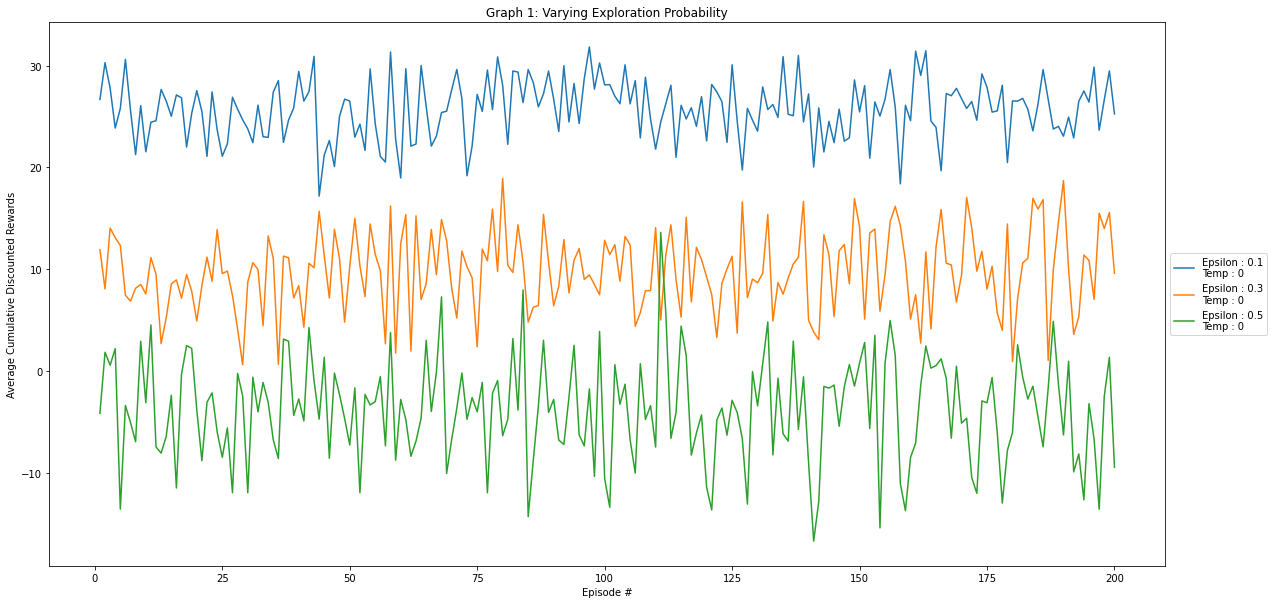

<Figure size 432x288 with 0 Axes>

In [15]:
# Graph 1
fig = plt.figure()
fig.set_figheight(10)
fig.set_figwidth(20)
plt.title("Graph 1: Varying Exploration Probability")
plt.xlabel("Episode #")
plt.ylabel("Average Cumulative Discounted Rewards")
[Q,policy] = rlProblem.qLearning(s0=0,initialQ=np.zeros([mdp.nActions,mdp.nStates]),nEpisodes=200,nSteps=100,epsilon=0.1,temperature=0)
print("Epsilon : 0.1")
print("Q : " + str(Q))
print("Policy : " + str(policy))
print("\n")
[Q,policy] = rlProblem.qLearning(s0=0,initialQ=np.zeros([mdp.nActions,mdp.nStates]),nEpisodes=200,nSteps=100,epsilon=0.3,temperature=0)
print("Epsilon : 0.3")
print("Q : " + str(Q))
print("Policy : " + str(policy))
print("\n")
[Q,policy] = rlProblem.qLearning(s0=0,initialQ=np.zeros([mdp.nActions,mdp.nStates]),nEpisodes=200,nSteps=100,epsilon=0.5,temperature=0)
print("Epsilon : 0.5")
print("Q : " + str(Q))
print("Policy : " + str(policy))
print("\n")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()
plt.savefig('TestRLmaze_Graph1.png', bbox_inches='tight')
plt.close()
plt.cla()
plt.clf()


---
## Part II.II: Q-Learning Algorithm - Average Cumulative Discounted rewards per episode for different Boltzmann Exploration Temperature. 
---
The execution results below show Graph 2, containing three curves corresponding to Boltzmann Exploration Temperatures T = 0, 10 and 20. Graph 1 uses boltzmann exploration temperature to choose an action with associated boltzman probability.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:74: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Temperature : 0
Q : [[ -7.28253677  31.12004208  -4.60520391  -4.89181387  -6.23033928
   29.20363076  -6.90931386  -6.08017842 -67.25857689 -74.90699795
  -24.21546894  -5.91887232  -3.26440427  -3.45891769 102.09196741
   -1.4601404   -8.52957343]
 [ -8.36086146  -6.42817216  -4.64650717  59.80349255  22.16742755
  -33.04602623  34.52612393  65.93374747 -34.36275022 -12.90866632
   -6.02400513  88.65256681  -3.76955155  55.04825153   0.
   -1.32420527  -8.02846795]
 [-10.39158245  -6.37735018  -5.57685411  -5.93622142  -9.12745206
  -68.65800682  -5.06661802  -5.87425535  31.49855332 -76.34358535
  -67.716396    -5.88012985  -3.68038339  -1.38081382   0.
   96.47458955   1.17087905]
 [ 23.10477012  -4.98875301  59.97060571  -5.23956659  -6.20418241
  -65.48916151  -5.30628761  -6.30872819 -35.07387184 -72.11213579
   60.81124124  -5.68700575  54.4496161   -0.87051342   0.
    0.          -7.34425819]]
Policy : [3 0 3 1 1 0 1 1 2 0 3 1 3 1 0 2 2]




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:74: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Temperature : 10
Q : [[ 5.46532485e+01  6.20812865e+01  6.77281434e+01  7.28168414e+01
   5.56410438e+01  6.04739369e+01  6.56986357e+01  7.31103861e+01
  -6.57761374e+01 -3.17384908e+00 -3.76972985e+01  8.62352662e+01
   3.76405192e+01 -6.65275881e+01  1.09409188e+02  9.13186676e+01
   1.03794089e+01]
 [ 5.85959480e+01  5.69166914e+01  6.28523845e+01  6.43671493e+01
   4.77948351e+01 -3.81183141e+01  5.24388335e+01  9.02153096e+01
  -6.46514865e+01 -2.94672067e+01  1.04106801e+02  9.58077980e+01
   4.30788490e+01  3.05629607e+01  0.00000000e+00  9.58847718e+01
   1.05723762e+01]
 [ 5.79638549e+01  6.49107997e+01  6.20129045e+01  6.94792570e+01
   5.87702077e+01 -2.47038177e+01  8.79741741e+01  7.04398775e+01
   4.39044156e+01 -2.68906957e+01 -3.96700988e+01  8.04424067e+01
   3.86991469e+01 -1.41499826e+01  0.00000000e+00  1.05319290e+02
   1.01196625e+01]
 [ 5.93247041e+01  6.87739289e+01  7.20921099e+01  8.48421110e+01
   5.71734677e+01 -2.59447121e+01  7.19661006e+01  7.09445323e+0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:74: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Temperature : 20
Q : [[ 67.68497397  69.47902414  69.1157648   72.46256619  74.23945073
   65.93936662  77.25961653  75.48792754  77.23561233 -11.16815754
    7.24384756  77.03983827  87.95114183   1.78142127 111.60785748
   87.01511592  11.80279778]
 [ 76.82600853  69.40304387  71.20861175  83.5749248   80.05134751
    2.58342293  82.72079933  89.41243707  88.27343495  29.3017318
   16.29095737  78.70806645  91.89897808  99.07563943 114.13758825
   97.14804677  11.63616197]
 [ 73.3276527   73.04393939  70.60978768  68.36513515  63.02630136
   56.814821    68.32033624  71.68394422  75.3785475   -0.63180266
   28.74367762  79.28370969  91.62417172  75.29806742 112.82382055
   92.2379804   11.64015188]
 [ 69.87374559  67.54840352  71.78937992  76.98547563  69.96483111
    6.34383927  66.34757433  81.77750507   5.61873733   9.57862361
   92.91070904  87.35951502  96.60099792 103.41507333 112.8883918
   84.53275258  11.47976658]]
Policy : [3 3 2 1 3 2 1 2 0 3 3 1 0 3 2 1 0]




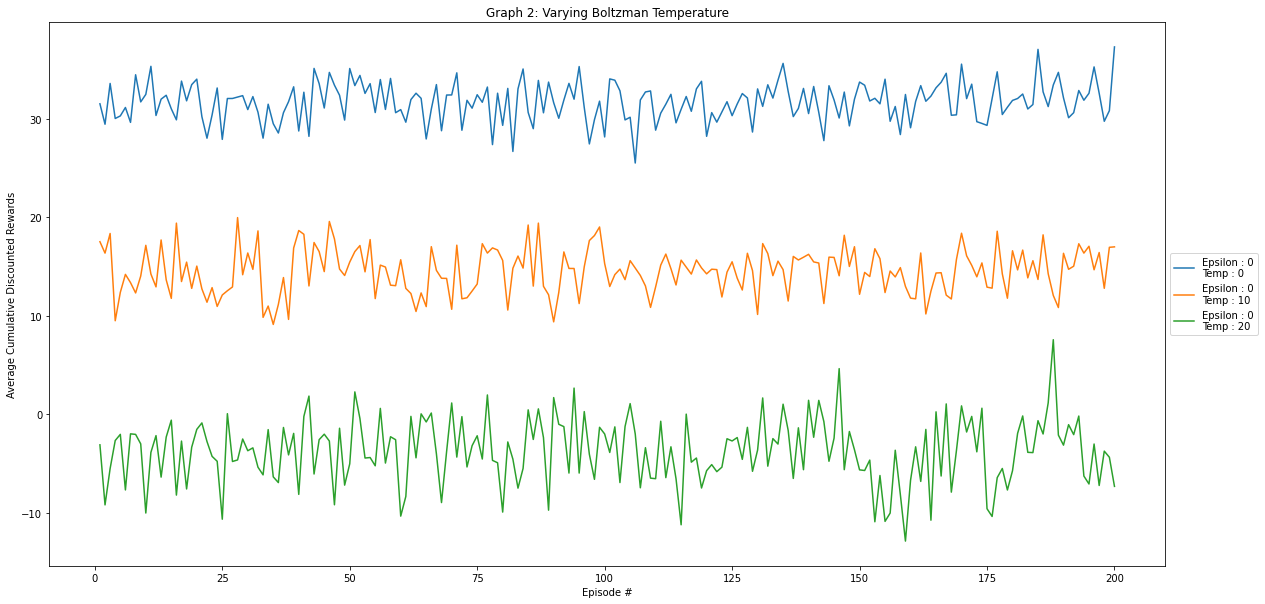

<Figure size 432x288 with 0 Axes>

In [16]:
# Graph 2
fig = plt.figure()
fig.set_figheight(10)
fig.set_figwidth(20)
plt.title("Graph 2: Varying Boltzman Temperature")
plt.xlabel("Episode #")
plt.ylabel("Average Cumulative Discounted Rewards")
[Q,policy] = rlProblem.qLearning(s0=0,initialQ=np.zeros([mdp.nActions,mdp.nStates]),nEpisodes=200,nSteps=100,epsilon=0,temperature=0)
print("Temperature : 0")
print("Q : " + str(Q))
print("Policy : " + str(policy))
print("\n")
[Q,policy] = rlProblem.qLearning(s0=0,initialQ=np.zeros([mdp.nActions,mdp.nStates]),nEpisodes=200,nSteps=100,epsilon=0,temperature=10)
print("Temperature : 10")
print("Q : " + str(Q))
print("Policy : " + str(policy))
print("\n")
[Q,policy] = rlProblem.qLearning(s0=0,initialQ=np.zeros([mdp.nActions,mdp.nStates]),nEpisodes=200,nSteps=100,epsilon=0,temperature=20)
print("Temperature : 20")
print("Q : " + str(Q))
print("Policy : " + str(policy))
print("\n")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()
plt.savefig('TestRLmaze_Graph2.png', bbox_inches='tight')
plt.close()
plt.cla()
plt.clf()


---
## Part II.III: Q-Learning Algorithm - Discussion
---
From Graph 1, we see that increasing the exploration probability reduces the average cumulative discounted rewards. We also observe that with increased exploration probability - exploitation of known best action reduces, resulting in increased randomness in Q-values and policy. 

And from Graph 2, we see that increasing the boltzman temperature also reduces the average cumulative discounted rewards. Increasing boltzmann temperature also reduces exploitation of of known best action reduces, resulting in increased randomness in Q-values and policy. 